In [1]:
#CONDA ENV: base
#Import packages
#---------------------------------------
import sys
import os
import glob
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import pysam as sam

#Import your modules
#---------------------------------------
sys.path.insert(1, '/cndd3/dburrows/CODE/admin_tools/')
from admin_tools import admin_functions as adm

# Define paths
#----------------------------------------------------------------------
l_code = '/Users/dominicburrows/Dropbox/PhD/Analysis/my_scripts/GitHub/'
l_data = '/Users/dominicburrows/Dropbox/PhD/analysis/Project/'
l_fig = '/Users/dominicburrows/Dropbox/PhD/figures/'

s_code = '/cndd3/dburrows/CODE/'
s_data = '/cndd3/dburrows/DATA/'
s_fig = '/cndd3/dburrows/FIGS/'

%load_ext autoreload
sys.version

'3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) \n[GCC 9.4.0]'

In [ ]:
def _group():
    

# Global methylation

In [97]:
# Load in global methylation
meth_df = pd.read_csv('/cndd2/jchien/project/Dracheva_Development/Individual_globalMethylation_autosome_cov3to50_all.tsv.gz', sep='\t', index_col=0)
meth_df['Sample ID'] = [meth_df['donor'][i] + '-' + meth_df['celltype'][i] for i in range(len(meth_df))]

# meth_str = [(meth_df.index[i] + '-' + meth_df['type'][i]).upper() for i in range(len(meth_df))]
# meth_str[np.where(np.asarray(meth_str) == 'HCTYPA008-GABA')[0][0]] = 'HctYPA008-GABA'
# meth_str[np.where(np.asarray(meth_str) == 'HCTYPA008-GLU')[0][0]] = 'HctYPA008-GLU'
# meth_df.index = meth_str

# Load in RNA
rna_df = pd.read_csv('/cndd/dburrows/DATA/te/rna/PE.counts/DE/ATEM_CPM.csv', index_col=0)

# Load in PE metadata
meta_df = pd.read_csv('/datasets/Public_Datasets/Dracheva_PsychEncode_development/processed/PEC_RNAmeta.csv')
#meta_df = pd.read_csv('/datasets/Public_Datasets/Dracheva_PsychEncode_development/processed/PEC_LIMS_11042022_mod.csv')

In [146]:
for k in hmc_df.keys():
    print(k, len(hmc_df[k]))

mCGlevel 169
mCHlevel 169
Sample ID 1
celltype 169
age 169
sex 169
age_binary 169


In [162]:
#Split data in total methylation, true methylation and hydroxymethylation
amc_df = meth_df[meth_df['assay'] == 'BS'] #all mc
amc_glu = amc_df[amc_df['celltype'] == 'GLU']
amc_gaba = amc_df[amc_df['celltype'] == 'GABA']

tmc_df = meth_df[meth_df['assay'] == 'oxBS'] #true mc
tmc_glu = tmc_df[tmc_df['celltype'] == 'GLU']
tmc_gaba = tmc_df[tmc_df['celltype'] == 'GABA']

#hydroxymethylation
unq = np.unique(meth_df['Sample ID'].values, return_counts=True)
rep_donors = unq[0][np.where(unq[1] > 1)[0]] #repeated donors

hmc_df = {'mCGlevel': [], 'mCHlevel':[] , 'Sample ID':rep_donors, 'celltype': [], 'age': [], 'sex': [], 'age_binary': []} #hydroxymc
for r in rep_donors:
    
    curr = meth_df[meth_df['Sample ID'] == r]
    bs = curr[curr['assay'] == 'BS']
    ox = curr[curr['assay'] == 'oxBS']
    assert len(bs) == 1 and len(ox) == 1, 'Error: more than one, or 0 BS or oxBS sample for donor {}'.format(r)
    hmc_df['mCGlevel'] = np.append(hmc_df['mCGlevel'], bs['mCGlevel'].values - ox['mCGlevel'].values)
    hmc_df['mCHlevel'] = np.append(hmc_df['mCHlevel'], bs['mCHlevel'].values - ox['mCHlevel'].values)
    hmc_df['celltype'] = np.append(hmc_df['celltype'], curr['celltype'].values[0])
    hmc_df['age'] = np.append(hmc_df['age'], curr['age'].values[0])
    hmc_df['sex'] = np.append(hmc_df['sex'], curr['sex'].values[0])
    hmc_df['age_binary'] = np.append(hmc_df['age_binary'], curr['age_binary'].values[0])

hmc_df = pd.DataFrame(hmc_df)
hmc_glu = hmc_df[hmc_df['celltype'] == 'GLU']
hmc_gaba = hmc_df[hmc_df['celltype'] == 'GABA']

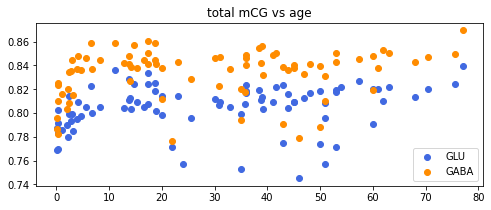

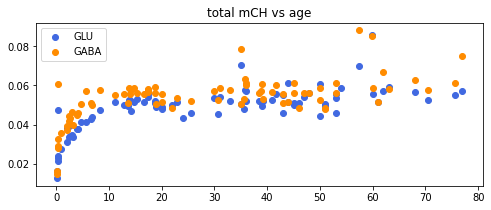

In [174]:
#Plot true methylation vs age
fig, ax = plt.subplots(figsize=(8, 3))
glu = amc_glu
gaba = amc_gaba
string = 'total'
plt.title(string+ ' mCG vs age')
plt.scatter(glu['age'], glu['mCGlevel'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba['mCGlevel'], label='GABA', c='darkorange')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
plt.title(string+' mCH vs age')
plt.scatter(glu['age'], glu['mCHlevel'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba['mCHlevel'], label='GABA', c='darkorange')
plt.legend()
plt.show()

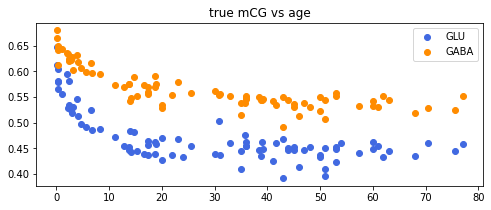

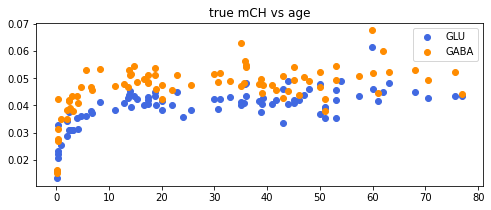

In [175]:
#Plot true methylation vs age
fig, ax = plt.subplots(figsize=(8, 3))
glu = tmc_glu
gaba = tmc_gaba
string = 'true'
plt.title(string+ ' mCG vs age')
plt.scatter(glu['age'], glu['mCGlevel'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba['mCGlevel'], label='GABA', c='darkorange')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
plt.title(string+' mCH vs age')
plt.scatter(glu['age'], glu['mCHlevel'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba['mCHlevel'], label='GABA', c='darkorange')
plt.legend()
plt.show()

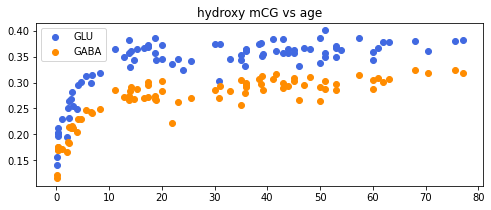

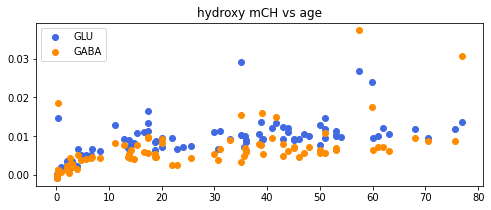

In [176]:
#Plot hydroxy-methylation vs age
fig, ax = plt.subplots(figsize=(8, 3))
glu = hmc_glu
gaba = hmc_gaba
string = 'hydroxy'
plt.title(string+ ' mCG vs age')
plt.scatter(glu['age'], glu['mCGlevel'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba['mCGlevel'], label='GABA', c='darkorange')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
plt.title(string+' mCH vs age')
plt.scatter(glu['age'], glu['mCHlevel'], label='GLU', c='royalblue')
plt.scatter(gaba['age'], gaba['mCHlevel'], label='GABA', c='darkorange')
plt.legend()
plt.show()

In [27]:
def _group():
    

,type,mCG,hmCG,CG,mCH,hmCH,CH,mCA,hmCA,CA
Sample,,,,,,,,,,
1277,GABA,0.517361,0.335540,0.147099,0.051186,0.019374,0.929441,0.089636,0.029042,0.881321
198035-1765,GABA,0.536855,0.334609,0.128536,0.037751,0.008342,0.953907,0.076011,0.019013,0.904976
198035-1765,Glu,0.419864,0.411043,0.169093,0.024873,0.011822,0.963305,0.054210,0.025118,0.920671
4332,GABA,0.608350,0.272392,0.119258,0.043552,0.004263,0.952185,0.089461,0.010642,0.899897
4332,Glu,0.491237,0.345524,0.163238,0.024044,0.006565,0.969391,0.052515,0.014252,0.933233
4336,GABA,0.580463,0.301331,0.118206,0.043021,0.006225,0.950755,0.088186,0.014494,0.897320
4336,Glu,0.449511,0.392934,0.157554,0.031656,0.010218,0.958126,0.066732,0.022628,0.910640
4379,GABA,0.639292,0.237434,0.123274,0.030851,0.003734,0.965415,0.067378,0.008659,0.923963
4379,Glu,0.519562,0.309152,0.171286,0.017197,0.004581,0.978222,0.041307,0.010517,0.948176


In [8]:
rna_df.columns.values

array(['1105-GABA', '1105-GLU', '1133-GABA', '1133-GLU', '1134-GABA',
       '1134-GLU', '1275-GABA', '1275-GLU', '1277-GABA', '1277-GLU',
       '1535-GLU', '1539-GABA', '1539-GLU', '1648-GABA', '1648-GLU',
       '1823-GABA', '1823-GLU', '1848-GABA', '1848-GLU', '3739-GLU',
       '4321-GABA', '4321-GLU', '4332-GABA', '4332-GLU', '4337-GABA',
       '4337-GLU', '4369-GABA', '4369-GLU', '4379-GABA', '4379-GLU',
       '4411-GABA', '4411-GLU', '4414-GABA', '4414-GLU', '4425-GABA',
       '4425-GLU', '4428-GABA', '4428-GLU', '4545-GABA', '4545-GLU',
       '4725-GABA', '4725-GLU', '5077-GABA', '5077-GLU', '5086-GABA',
       '5086-GLU', '5161-GABA', '5161-GLU', '5184-GABA', '5184-GLU',
       '5293-GABA', '5293-GLU', '5309-GABA', '5309-GLU', '5326-GABA',
       '5326-GLU', '5387-GABA', '5387-GLU', '5401-GABA', '5401-GLU',
       '5446-GABA', '5446-GLU', '5451-GABA', '5451-GLU', '5570-GABA',
       '5570-GLU', '5606-GABA', '5606-GLU', '5617-GABA', '5617-GLU',
       '5643-GABA', '5643-GL

In [76]:
len(meta_df), len(meth_df)

(116, 41)

In [53]:
#find the samples that are in both
for m in meth_str:
    if m not in rna_df.columns.values:
        print(m)

4336-GABA
4336-GLU
4422-GABA
4422-GLU
HCTZZHA019-GABA
HCTZZHA019-GLU
1790-GABA
1864-GLU
390-GABA
390-GLU
4782-GABA


In [35]:
count=0
#find the samples that are in both
for m in rna_df.columns.values:

    print(m)

1105-GABA
1105-GLU
1133-GABA
1133-GLU
1134-GABA
1134-GLU
1275-GABA
1275-GLU
1277-GABA
1277-GLU
1535-GLU
1539-GABA
1539-GLU
1648-GABA
1648-GLU
1823-GABA
1823-GLU
1848-GABA
1848-GLU
3739-GLU
4321-GABA
4321-GLU
4332-GABA
4332-GLU
4337-GABA
4337-GLU
4369-GABA
4369-GLU
4379-GABA
4379-GLU
4411-GABA
4411-GLU
4414-GABA
4414-GLU
4425-GABA
4425-GLU
4428-GABA
4428-GLU
4545-GABA
4545-GLU
4725-GABA
4725-GLU
5077-GABA
5077-GLU
5086-GABA
5086-GLU
5161-GABA
5161-GLU
5184-GABA
5184-GLU
5293-GABA
5293-GLU
5309-GABA
5309-GLU
5326-GABA
5326-GLU
5387-GABA
5387-GLU
5401-GABA
5401-GLU
5446-GABA
5446-GLU
5451-GABA
5451-GLU
5570-GABA
5570-GLU
5606-GABA
5606-GLU
5617-GABA
5617-GLU
5643-GABA
5643-GLU
5744-GABA
5744-GLU
5787-GABA
5787-GLU
5871-GABA
5871-GLU
5918-GABA
5918-GLU
5936-GABA
5936-GLU
5976-GABA
5976-GLU
5977-GABA
5977-GLU
6007-GABA
6007-GLU
6032-GABA
6032-GLU
6285-GABA
6285-GLU
1241-GABA
1241-GLU
179134-1401-GABA
179134-1401-GLU
198034-1435-GABA
198034-1435-GLU
198035-1765-GABA
198035-1765-GLU
Hct15HAWA

In [24]:
len(rna_df.columns.values)

116

In [22]:
count=0
#find the samples that are in both
for m in rna_df.columns.values:
    if m not in meth_str:
        count+=1
        print(m)

1105-GABA
1105-GLU
1133-GABA
1133-GLU
1134-GABA
1134-GLU
1277-GLU
1535-GLU
1539-GABA
1539-GLU
1648-GABA
1648-GLU
1823-GABA
1823-GLU
1848-GABA
1848-GLU
3739-GLU
4337-GABA
4337-GLU
4369-GABA
4369-GLU
4414-GABA
4414-GLU
4425-GABA
4428-GABA
4428-GLU
4545-GABA
4545-GLU
4725-GABA
4725-GLU
5077-GABA
5077-GLU
5086-GABA
5086-GLU
5161-GABA
5161-GLU
5184-GABA
5184-GLU
5293-GABA
5293-GLU
5309-GABA
5309-GLU
5326-GABA
5326-GLU
5387-GABA
5387-GLU
5401-GLU
5446-GABA
5446-GLU
5451-GABA
5451-GLU
5570-GABA
5570-GLU
5643-GABA
5643-GLU
5744-GABA
5744-GLU
5787-GABA
5787-GLU
5871-GABA
5871-GLU
5918-GABA
5918-GLU
6032-GABA
6032-GLU
6285-GABA
6285-GLU
1241-GABA
179134-1401-GABA
179134-1401-GLU
198034-1435-GABA
198034-1435-GLU
Hct15HAWA031-GABA
Hct15HAWA031-GLU
Hct15HBMA007-GABA
Hct15HBMA007-GLU
Hct15HBNA032-GABA
Hct15HBNA032-GLU
Hct16HCQA020-GABA
Hct16HCQA020-GLU
Hct16HECA028-GABA
Hct16HECA028-GLU
Hct17HEIA010-GABA
Hct17HEIA010-GLU
HctYPA008-GABA
HctYPA008-GLU
HctZZNA014-GABA
HctZZNA014-GLU


In [18]:
meth_str = [(meth_df.index[i] + '-' + meth_df['type'][i]).upper() for i in range(len(meth_df))]
meth_str

['1277-GABA',
 '198035-1765-GABA',
 '198035-1765-GLU',
 '4332-GABA',
 '4332-GLU',
 '4336-GABA',
 '4336-GLU',
 '4379-GABA',
 '4379-GLU',
 '4422-GABA',
 '4422-GLU',
 '6007-GABA',
 '6007-GLU',
 'HCTYPA008-GABA',
 'HCTYPA008-GLU',
 'HCTZZHA019-GABA',
 'HCTZZHA019-GLU',
 '1241-GLU',
 '1275-GABA',
 '1275-GLU',
 '1790-GABA',
 '1864-GLU',
 '390-GABA',
 '390-GLU',
 '4321-GABA',
 '4321-GLU',
 '4411-GABA',
 '4411-GLU',
 '4425-GLU',
 '4782-GABA',
 '5401-GABA',
 '5606-GABA',
 '5606-GLU',
 '5617-GABA',
 '5617-GLU',
 '5936-GABA',
 '5936-GLU',
 '5976-GABA',
 '5976-GLU',
 '5977-GABA',
 '5977-GLU']

In [14]:
meth_df['type']

Sample
1277           GABA
198035-1765    GABA
198035-1765     Glu
4332           GABA
4332            Glu
4336           GABA
4336            Glu
4379           GABA
4379            Glu
4422           GABA
4422            Glu
6007           GABA
6007            Glu
HCTYPA008      GABA
HCTYPA008       Glu
HCTZZHA019     GABA
HCTZZHA019      Glu
1241            Glu
1275           GABA
1275            Glu
1790           GABA
1864            Glu
390            GABA
390             Glu
4321           GABA
4321            Glu
4411           GABA
4411            Glu
4425            Glu
4782           GABA
5401           GABA
5606           GABA
5606            Glu
5617           GABA
5617            Glu
5936           GABA
5936            Glu
5976           GABA
5976            Glu
5977           GABA
5977            Glu
Name: type, dtype: object